# Analysis for Spotify Trends

# Introduction

The dataset we are going to be using for this analysis is going to be based on Spotify Data. The main reason behind this is trying to undertand what makes music likeable and apt in certain situation and providing analysis to allow for artists to make use of that information.

Below, I have described our data and the questions that we will be answering, its signifance, relevance and how someone can benifit from this information.

**The dataset we plan to extract consists of genre and time-period based data and randomly samples 90 songs from a larger dataset (these parameters can be adjusted as well). For each of those 90 tracks we have a lot of information as described a few cells below. Using this, we hope to answer the following questions:**

### Motivation

As a group we are very passionate about music and some of us play instruments as well. In such a scenario and with the rise of new stars almost daily, we felt that its a good idea to learn what makes music the way it is. Specifically we wanted to the answers to a few questions as listed below.

Spotify is the one of the most popular platforms used to listen to music and hence working on data used from that website provides us with a large and almost completely representative population on an international scale.

*Note:* We chose 'Pop' as the main genre for analyzing the following data

### Research Questions

**Descriptive and Data Based Analysis:**<br>
--> What is the relationship between danceability and other variables in the dataset? (Danceability of a song can greatly impact the popularity of a song. Therefore, an intresting thing to look at)<br> 
--> What is the relationship between danceability and Valence (Strongest correlation for danceability)? <br>
--> What is the impact of Major/Minor on the relation between Danceability and Valence?

**Inference Based Analysis:**<br>
--> Is there sufficient evidence to suggest that there is an association between Energy pop song and it being Major/ Minor

**Linear Regression Based Analysis:**<br>
--> Is there a linear relation between energy and loudness, valence, liveness, key, acousticness, instrumentalness <br>
(We are picking the variables based on correlation) (Energy was chosen as it seemed to have its variabilty be explained by multiple other variables) (Keys was picked at was the only other categorical variables besides Major/Minor)<br>
-->Is there a linear relation betweenenergy and loudness, valence, liveness, key, acousticness, instrumentalness in the population of all songs in spotify? 

**Logistic Regression Based Analysis:**<br>
--> I will fill this out when I get to logistic regression, but I will be predicting the mode of the song, i.e. if its major or minor


***There is a lot of use for this data, especially producers trying to sign on new artists, for creators to make advantage of this for social media leverage in addition to the instrinsic value this bings the creator. They can use this data to understand what musical features make a song gain certain characteristics and it can also be used to monetize their art in the same capacity***

## Data Extraction from Spotify

For this project we have used the spotify API for data extraction and since we will be conducting inference as well as regression based analysis we needed to maintain certain features within the DataSet

1) It needed to be a random sample (true randomness does not exists, therefore we can say its pseudorandom)
2) The size of the dataset needs to be less than 10% of the total population by size
3) Implement a function for extracting the data so someone else can conduct this same analysis later on on a slightly different dataset, with parameters they decide upon.

*Note: Before diving further deeper into the dataset and what it does, I am going to extract the data and clean it*

#### Getting the Spotify API setup

In [47]:
# Import for data cleaning and othe function as well
import spotipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [48]:
# Would need to use the secrets file, if this was not a dummy account

SPOTIPY_CLIENT_ID = '544d6eb7a5c14986bdd9727cf2b40f9d'
SPOTIPY_CLIENT_SECRET = '631e2374886c4d508cbcc8b83afa3dd3' # This secret can be rotated later to prevent maluse
PORT_NUMBER = 8080

client_credentials_manager = spotipy.SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

sp


#### Getting the Pseudo Random Song Samples with specific parameters

In [49]:
def get_random_songs(number_of_songs=1, genre='Pop', year_range='2011-2022', random_state = 101):
    #Set random seed
    import random
    random.seed(random_state)

    #Generate random offsets (sampling without replacement)
    random_offset = random.sample(range(0, 900), number_of_songs)

    #Generate random search character for query (sampling with replacement)
    chars = 'abcdefghijklmnopqrstuvwxyz'
    random_char = random.choices(chars, k=number_of_songs)

    #Generate random id to select in the output list of 10 (sampling with replacement)
    random_id = random.choices(range(0, 10), k=number_of_songs)

    df_random_songs = pd.DataFrame(columns=['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id', 'album_name', 'release_date'])

    for i in range(0,number_of_songs):
        #Pseudo-random query selection
        results = sp.search(q='genre:' + genre + ' year:' + year_range+' '+random_char[i], type='track', offset=random_offset[i])

        song_list = []
        #Adding track info
        song_list.append(results['tracks']['items'][random_id[i]]['id'])
        song_list.append(results['tracks']['items'][random_id[i]]['name'])

        #Adding artist info (first one listed)
        song_list.append(results['tracks']['items'][random_id[i]]['artists'][0]['id'])
        song_list.append(results['tracks']['items'][random_id[i]]['artists'][0]['name'])

        #Adding album info
        song_list.append(results['tracks']['items'][random_id[i]]['album']['id'])
        song_list.append(results['tracks']['items'][random_id[i]]['album']['name'])
        song_list.append(results['tracks']['items'][random_id[i]]['album']['release_date'])

        df_song = pd.DataFrame([song_list], columns=['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id', 'album_name', 'release_date'])

        df_random_songs=pd.concat([df_random_songs, df_song])

    df_random_songs=df_random_songs.reset_index(drop=True)
    
    return df_random_songs    
    

In [50]:
def get_song_info(track_uri):
    #1. Extract the audio features of the track
    song_results = sp.audio_features(track_uri)
    
    #2. Collect the following audio information about the track
    song_list=[track_uri.split(':')[2],
               song_results[0]['danceability'],
               song_results[0]['energy'],
               song_results[0]['key'],
               song_results[0]['loudness'],
               song_results[0]['mode'],
               song_results[0]['speechiness'],
               song_results[0]['acousticness'],
               song_results[0]['instrumentalness'],
               song_results[0]['liveness'],
               song_results[0]['valence'],
               song_results[0]['tempo'],
               song_results[0]['type'],
               song_results[0]['time_signature']]
               
    
    df_song_audio=pd.DataFrame([song_list], columns=['track_id', 'danceability', 'energy', 'key', 'loudness', 'mode',
                                                    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
                                                    'tempo', 'type', 'time_signature'])
    return df_song_audio
    

In [51]:
#Creating a dataset that is Genre Specific with 900 songs i.e. here we have chosen Pop for our dataset, but the code allows us to change the question later
#Note: as mentioned below, we will only be using pop songs for the analysis


# df = get_random_songs(number_of_songs=900, genre='Pop', year_range='2011-2022', random_state = 100) commented since it takes too long to run, but we ran it to make the csv file

# #Creates an empty dataframe with the columns that we want
# song_audio_info = pd.DataFrame(columns=['track_id', 'tempo',
#                                            'danceability', 'energy', 'key',
#                                            'loudness', 'acousticness', 'instrumentalness',
#                                            'liveness', 'valence'])


# for track_id in df['track_id']:
#     #print(track_id)
#     song_audio_info = pd.concat([song_audio_info, get_song_info('spotify:track:'+track_id)])
    

# df= pd.merge(df,song_audio_info, on=['track_id'])
# df.head()

# Note: I commented it out since, it takes too long to run, we ran it during data collection to make the csv file

In [52]:
# Going to save this data and push it to the repo, since running the above function takes a long time
#   ...the below code is only for time saving purposes, so we meed not run the API call multiple times
#   ...also if the internet connection fails, then too we need a dataset that allows for analysis without having to get new data



# df.to_csv(r"extracted_uncleaned_data.csv", header=True, index = False)
# data = pd.read_csv('extracted_uncleaned_data.csv')
# data.head()



## df = data # This line can be used in the above mentioned scenario

In [53]:
# Only reason for running this statement is that the dataset needed for analysis cannot keep changing, since its random
# Which is why, the above line is commented out, so that if someone runs the code again, the extracted data does not change
df = pd.read_csv('extracted_uncleaned_data.csv')
df

,track_id,track_name,artist_id,artist_name,album_id,album_name,release_date,tempo,danceability,energy,key,loudness,acousticness,instrumentalness,liveness,valence,mode,speechiness,type,time_signature
0,2ihCaVdNZmnHZWt0fvAM7B,Little Talks,4dwdTW1Lfiq0cM8nBAqIIz,Of Monsters and Men,4p9dVvZDaZliSjTCbFRhJy,My Head Is An Animal,2012-01-01,102.961,0.457,0.757,1,-5.177,0.020600,0.000000,0.1460,0.417,1.0,0.0320,audio_features,4.0
1,77UjLW8j5UAGAGVGhR5oUK,Pray For Me (with Kendrick Lamar),1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,3pLdWdkj83EYfDN6H2N8MR,Black Panther The Album Music From And Inspire...,2018-02-09,100.584,0.735,0.677,2,-4.979,0.076200,0.000022,0.1110,0.188,1.0,0.0930,audio_features,4.0
2,4B0JvthVoAAuygILe3n4Bs,What Do You Mean?,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,6Fr2rQkZ383FcMqFyT7yPr,Purpose (Deluxe),2015-11-13,125.020,0.845,0.567,5,-8.118,0.590000,0.001420,0.0811,0.793,0.0,0.0956,audio_features,4.0
3,6ylDpki1VpIsc525KC1ojF,Tacones Rojos,07YUOmWljBTXwIseAUd9TW,Sebastian Yatra,4qgRDM8Gyurf5hXV3LBmT8,Dharma,2022-01-28,123.014,0.746,0.844,11,-3.499,0.062000,0.000000,0.1490,0.934,0.0,0.0359,audio_features,4.0
4,06cCziAHtDg6pcsidZHu03,Robbers,3mIj9lX2MWuHmhNCA7LSCW,The 1975,0mkOUedmYlOzCC4tOm2v0c,The 1975 (Deluxe Version),2013,99.808,0.621,0.702,4,-6.845,0.000332,0.000015,0.3220,0.374,1.0,0.0295,audio_features,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,0tYZo2UhV1lrUez5CA0Iyw,Guerrilla,68KmkJeZGfwe1OUaivBa2L,ATEEZ,3fgDrbflffzvV3H3plG9e6,THE WORLD EP.1 : MOVEMENT,2022-07-29,181.963,0.555,0.890,9,-5.349,0.003990,0.000000,0.0506,0.581,1.0,0.1320,audio_features,4.0
1060,4xFcQGVBVakReaL0OOJiP6,Follow,60d24wfXkVzDSfLS6hyCjZ,Martin Garrix,45gsxfnJ5Nt2RZp82SQenc,Sentio,2022-04-29,127.085,0.588,0.780,11,-6.102,0.033300,0.193000,0.0728,0.201,0.0,0.0432,audio_features,4.0
1061,65krgqLiZqW12PZAUQ9l2x,Velvet Elvis,70kkdajctXSbqSMJbQO424,Kacey Musgraves,7f6xPqyaolTiziKf5R5Z0c,Golden Hour,2018-03-30,89.988,0.677,0.616,1,-5.241,0.173000,0.000000,0.0427,0.736,1.0,0.0320,audio_features,4.0
1062,0wv1GksE3pRdl4F2NqdMDL,Dancing Queen,72OaDtakiy6yFqkt4TsiFt,Cher,5fQGgxRgeSOOLJoyatusfN,Happy New Year 2023,2022-12-02,103.281,0.600,0.942,9,-3.865,0.111000,0.000000,0.3380,0.417,1.0,0.0543,audio_features,4.0


**Note:** As part of data cleaning, we need to also remove duplicate values

### Data Exploration

#### What the Data Means:

1) **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

2) **analysis_url**: A URL to access the full audio analysis of this track. An access token is required to access this data.


3) **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

4) **duration_ms**: The duration of the track in milliseconds.

5) **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

6) **id**: The Spotify ID for the track.

7) **instrumentalness**: Predicts whether a track contains no vocals. **Ooh** and **aah** sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly **vocal**. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

8) **key**: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

9) **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

10) **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

11) **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

12) **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

13) **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

14) **time_signature**: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of **3/4**, to **7/4**.

15) **track_href**: A link to the Web API endpoint providing full details of the track.

16) **type**: **audio_features**, this is not very informative, but is information provided by the API

17) **uri**: The Spotify URI for the track.

18) **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


*Note: Some of this is in a data type that is not ideal or simple for analysis and hence it needs to be recoded while performing the cleaning part*

For more information refer : https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          1064 non-null   object 
 1   track_name        1064 non-null   object 
 2   artist_id         1064 non-null   object 
 3   artist_name       1064 non-null   object 
 4   album_id          1064 non-null   object 
 5   album_name        1064 non-null   object 
 6   release_date      1064 non-null   object 
 7   tempo             1064 non-null   float64
 8   danceability      1064 non-null   float64
 9   energy            1064 non-null   float64
 10  key               1064 non-null   int64  
 11  loudness          1064 non-null   float64
 12  acousticness      1064 non-null   float64
 13  instrumentalness  1064 non-null   float64
 14  liveness          1064 non-null   float64
 15  valence           1064 non-null   float64
 16  mode              1064 non-null   float64


**Note:** As shown above some of the datatypes are not representative of its values and hence need to be recoded, in addition to checking for missing values and basic cleaning.

## Data Cleaning and Pre-Processing

In [55]:
# Dropping this column since its not helpful for analysis
df = df.drop(columns=['type'])
df.head()

,track_id,track_name,artist_id,artist_name,album_id,album_name,release_date,tempo,danceability,energy,key,loudness,acousticness,instrumentalness,liveness,valence,mode,speechiness,time_signature
0,2ihCaVdNZmnHZWt0fvAM7B,Little Talks,4dwdTW1Lfiq0cM8nBAqIIz,Of Monsters and Men,4p9dVvZDaZliSjTCbFRhJy,My Head Is An Animal,2012-01-01,102.961,0.457,0.757,1,-5.177,0.020600,0.000000,0.1460,0.417,1.0,0.0320,4.0
1,77UjLW8j5UAGAGVGhR5oUK,Pray For Me (with Kendrick Lamar),1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,3pLdWdkj83EYfDN6H2N8MR,Black Panther The Album Music From And Inspire...,2018-02-09,100.584,0.735,0.677,2,-4.979,0.076200,0.000022,0.1110,0.188,1.0,0.0930,4.0
2,4B0JvthVoAAuygILe3n4Bs,What Do You Mean?,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,6Fr2rQkZ383FcMqFyT7yPr,Purpose (Deluxe),2015-11-13,125.020,0.845,0.567,5,-8.118,0.590000,0.001420,0.0811,0.793,0.0,0.0956,4.0
3,6ylDpki1VpIsc525KC1ojF,Tacones Rojos,07YUOmWljBTXwIseAUd9TW,Sebastian Yatra,4qgRDM8Gyurf5hXV3LBmT8,Dharma,2022-01-28,123.014,0.746,0.844,11,-3.499,0.062000,0.000000,0.1490,0.934,0.0,0.0359,4.0
4,06cCziAHtDg6pcsidZHu03,Robbers,3mIj9lX2MWuHmhNCA7LSCW,The 1975,0mkOUedmYlOzCC4tOm2v0c,The 1975 (Deluxe Version),2013,99.808,0.621,0.702,4,-6.845,0.000332,0.000015,0.3220,0.374,1.0,0.0295,4.0


In [56]:
# Checking for obvious missing values and NaN values
df.isna().sum()

track_id            0
track_name          0
artist_id           0
artist_name         0
album_id            0
album_name          0
release_date        0
tempo               0
danceability        0
energy              0
key                 0
loudness            0
acousticness        0
instrumentalness    0
liveness            0
valence             0
mode                0
speechiness         0
time_signature      0
dtype: int64

In [57]:
df.dtypes

track_id             object
track_name           object
artist_id            object
artist_name          object
album_id             object
album_name           object
release_date         object
tempo               float64
danceability        float64
energy              float64
key                   int64
loudness            float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
mode                float64
speechiness         float64
time_signature      float64
dtype: object

**Recoding/ Encoding Style:**

***Even though the above dataset shows float64 type, that is not true when directly extracted. In that case its an object type, only since we read from csv it remains float. The encoding below just ensures the type***

1) tempo : needs to become an int/float

2) danceability: needs to become a float

3) energy: needs to become a float

4) key: needs to become a Letter based object (not a must for analysis, but imporoves the understandability of the code)

5) loudness: needs to become a float

6) acousticness: needs to become a float

7) instrumentalness: needs to become a float

8) liveness: needs to become a float

9) valence: needs to become a float 

10 mode: needs to become a String : "Major" / "Minor"

*Therefore, we have 3 types of encoding to be done:*

**1) Encoding to floating point type**

**2) Encoding mode to String type**

**3) Making key a String types as well**





In [58]:
# Checking for some basic data if there are any missing values not detected by the above check
# Only checking for these since the rest needs to be encoded
df['track_id'].unique()
df['track_name'].unique()
df['album_id'].unique()
df['album_name'].unique()
df['release_date'].unique()
print("Manually checked for all above columns/values and can conclude that they are no missing values")




Manually checked for all above columns/values and can conclude that they are no missing values


### Encoding to a floating Point type:


In [59]:
# Checkin for nan values here
df['tempo'].unique()
df['danceability'].unique()
df['energy'].unique()
df['loudness'].unique()
df['acousticness'].unique()
df['instrumentalness'].unique()
df['liveness'].unique()
df['valence'].unique()
print("Manually checked for all above columns/values and can conclude that they are no missing values")

# While they show as object type, when trying to check an individual value, thay act as a float. Hence going to change values just for good measure
# It aslo helps with rounding some value

Manually checked for all above columns/values and can conclude that they are no missing values


In [60]:
#Even though the above dataset shows float64 type, that is not true when directly extracted. In that case its an object type, only since we read from csv it remains float. The encoding below just ensures the type

df['tempo'] = df['tempo'].astype(float)
df['danceability'] = df['danceability'].astype(float)
df['energy'] = df['energy'].astype(float)
df['loudness'] = df['loudness'].astype(float)
df['acousticness'] = df['acousticness'].astype(float)
df['instrumentalness'] = df['instrumentalness'].astype(float)
df['liveness'] = df['liveness'].astype(float)
df['valence'] = df['valence'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          1064 non-null   object 
 1   track_name        1064 non-null   object 
 2   artist_id         1064 non-null   object 
 3   artist_name       1064 non-null   object 
 4   album_id          1064 non-null   object 
 5   album_name        1064 non-null   object 
 6   release_date      1064 non-null   object 
 7   tempo             1064 non-null   float64
 8   danceability      1064 non-null   float64
 9   energy            1064 non-null   float64
 10  key               1064 non-null   int64  
 11  loudness          1064 non-null   float64
 12  acousticness      1064 non-null   float64
 13  instrumentalness  1064 non-null   float64
 14  liveness          1064 non-null   float64
 15  valence           1064 non-null   float64
 16  mode              1064 non-null   float64


In [61]:
df = df.drop_duplicates(subset=['track_id'])

In [62]:
df

,track_id,track_name,artist_id,artist_name,album_id,album_name,release_date,tempo,danceability,energy,key,loudness,acousticness,instrumentalness,liveness,valence,mode,speechiness,time_signature
0,2ihCaVdNZmnHZWt0fvAM7B,Little Talks,4dwdTW1Lfiq0cM8nBAqIIz,Of Monsters and Men,4p9dVvZDaZliSjTCbFRhJy,My Head Is An Animal,2012-01-01,102.961,0.457,0.757,1,-5.177,0.020600,0.000000,0.1460,0.417,1.0,0.0320,4.0
1,77UjLW8j5UAGAGVGhR5oUK,Pray For Me (with Kendrick Lamar),1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,3pLdWdkj83EYfDN6H2N8MR,Black Panther The Album Music From And Inspire...,2018-02-09,100.584,0.735,0.677,2,-4.979,0.076200,0.000022,0.1110,0.188,1.0,0.0930,4.0
2,4B0JvthVoAAuygILe3n4Bs,What Do You Mean?,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,6Fr2rQkZ383FcMqFyT7yPr,Purpose (Deluxe),2015-11-13,125.020,0.845,0.567,5,-8.118,0.590000,0.001420,0.0811,0.793,0.0,0.0956,4.0
3,6ylDpki1VpIsc525KC1ojF,Tacones Rojos,07YUOmWljBTXwIseAUd9TW,Sebastian Yatra,4qgRDM8Gyurf5hXV3LBmT8,Dharma,2022-01-28,123.014,0.746,0.844,11,-3.499,0.062000,0.000000,0.1490,0.934,0.0,0.0359,4.0
4,06cCziAHtDg6pcsidZHu03,Robbers,3mIj9lX2MWuHmhNCA7LSCW,The 1975,0mkOUedmYlOzCC4tOm2v0c,The 1975 (Deluxe Version),2013,99.808,0.621,0.702,4,-6.845,0.000332,0.000015,0.3220,0.374,1.0,0.0295,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,0tYZo2UhV1lrUez5CA0Iyw,Guerrilla,68KmkJeZGfwe1OUaivBa2L,ATEEZ,3fgDrbflffzvV3H3plG9e6,THE WORLD EP.1 : MOVEMENT,2022-07-29,181.963,0.555,0.890,9,-5.349,0.003990,0.000000,0.0506,0.581,1.0,0.1320,4.0
1060,4xFcQGVBVakReaL0OOJiP6,Follow,60d24wfXkVzDSfLS6hyCjZ,Martin Garrix,45gsxfnJ5Nt2RZp82SQenc,Sentio,2022-04-29,127.085,0.588,0.780,11,-6.102,0.033300,0.193000,0.0728,0.201,0.0,0.0432,4.0
1061,65krgqLiZqW12PZAUQ9l2x,Velvet Elvis,70kkdajctXSbqSMJbQO424,Kacey Musgraves,7f6xPqyaolTiziKf5R5Z0c,Golden Hour,2018-03-30,89.988,0.677,0.616,1,-5.241,0.173000,0.000000,0.0427,0.736,1.0,0.0320,4.0
1062,0wv1GksE3pRdl4F2NqdMDL,Dancing Queen,72OaDtakiy6yFqkt4TsiFt,Cher,5fQGgxRgeSOOLJoyatusfN,Happy New Year 2023,2022-12-02,103.281,0.600,0.942,9,-3.865,0.111000,0.000000,0.3380,0.417,1.0,0.0543,4.0


### Encoding Mode to a String Type

For this, I am going to create a new column in the dataset which contains the same information.

**Reason**: Mode as 1/0 helps with regression as well, for example a minor song may not be good for dancing. Cannot say for sure though, its good not to loose it

In [63]:
data = []
for i in df['mode']:
    if (i == 1.0):
        data.append('Major')
    else:
        data.append('Minor')
df['Major_or_Minor'] = data
df.head()


,track_id,track_name,artist_id,artist_name,album_id,album_name,release_date,tempo,danceability,energy,key,loudness,acousticness,instrumentalness,liveness,valence,mode,speechiness,time_signature,Major_or_Minor
0,2ihCaVdNZmnHZWt0fvAM7B,Little Talks,4dwdTW1Lfiq0cM8nBAqIIz,Of Monsters and Men,4p9dVvZDaZliSjTCbFRhJy,My Head Is An Animal,2012-01-01,102.961,0.457,0.757,1,-5.177,0.020600,0.000000,0.1460,0.417,1.0,0.0320,4.0,Major
1,77UjLW8j5UAGAGVGhR5oUK,Pray For Me (with Kendrick Lamar),1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,3pLdWdkj83EYfDN6H2N8MR,Black Panther The Album Music From And Inspire...,2018-02-09,100.584,0.735,0.677,2,-4.979,0.076200,0.000022,0.1110,0.188,1.0,0.0930,4.0,Major
2,4B0JvthVoAAuygILe3n4Bs,What Do You Mean?,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,6Fr2rQkZ383FcMqFyT7yPr,Purpose (Deluxe),2015-11-13,125.020,0.845,0.567,5,-8.118,0.590000,0.001420,0.0811,0.793,0.0,0.0956,4.0,Minor
3,6ylDpki1VpIsc525KC1ojF,Tacones Rojos,07YUOmWljBTXwIseAUd9TW,Sebastian Yatra,4qgRDM8Gyurf5hXV3LBmT8,Dharma,2022-01-28,123.014,0.746,0.844,11,-3.499,0.062000,0.000000,0.1490,0.934,0.0,0.0359,4.0,Minor
4,06cCziAHtDg6pcsidZHu03,Robbers,3mIj9lX2MWuHmhNCA7LSCW,The 1975,0mkOUedmYlOzCC4tOm2v0c,The 1975 (Deluxe Version),2013,99.808,0.621,0.702,4,-6.845,0.000332,0.000015,0.3220,0.374,1.0,0.0295,4.0,Major


### Encoding the Key

In [64]:
df['key'].unique()

array([ 1,  2,  5, 11,  4, 10,  9,  8,  6,  0,  7,  3])

In [65]:
# Unlike the previous value, I am going to be recoding the value in place

data = []
for i in df['key']:
    if (i == -1):
        data.append('Missing Value') # I would clean this, but as we can see above, this never occurs
    if (i == 0):
        data.append('C')
    if (i == 1):
        data.append('C#')
    if (i == 2):
        data.append('D')
    if (i == 3):
        data.append('D#')
    if (i == 4):
        data.append('E')
    if (i == 5):
        data.append('F')
    if (i == 6):
        data.append('F#')
    if (i == 7):
        data.append('G')
    if (i == 8):
        data.append('G#')
    if (i == 9):
        data.append('A')
    if (i == 10):
        data.append('A#')
    if (i == 11):
        data.append('B')
df['key'] = data
df.head()

,track_id,track_name,artist_id,artist_name,album_id,album_name,release_date,tempo,danceability,energy,key,loudness,acousticness,instrumentalness,liveness,valence,mode,speechiness,time_signature,Major_or_Minor
0,2ihCaVdNZmnHZWt0fvAM7B,Little Talks,4dwdTW1Lfiq0cM8nBAqIIz,Of Monsters and Men,4p9dVvZDaZliSjTCbFRhJy,My Head Is An Animal,2012-01-01,102.961,0.457,0.757,C#,-5.177,0.020600,0.000000,0.1460,0.417,1.0,0.0320,4.0,Major
1,77UjLW8j5UAGAGVGhR5oUK,Pray For Me (with Kendrick Lamar),1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,3pLdWdkj83EYfDN6H2N8MR,Black Panther The Album Music From And Inspire...,2018-02-09,100.584,0.735,0.677,D,-4.979,0.076200,0.000022,0.1110,0.188,1.0,0.0930,4.0,Major
2,4B0JvthVoAAuygILe3n4Bs,What Do You Mean?,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,6Fr2rQkZ383FcMqFyT7yPr,Purpose (Deluxe),2015-11-13,125.020,0.845,0.567,F,-8.118,0.590000,0.001420,0.0811,0.793,0.0,0.0956,4.0,Minor
3,6ylDpki1VpIsc525KC1ojF,Tacones Rojos,07YUOmWljBTXwIseAUd9TW,Sebastian Yatra,4qgRDM8Gyurf5hXV3LBmT8,Dharma,2022-01-28,123.014,0.746,0.844,B,-3.499,0.062000,0.000000,0.1490,0.934,0.0,0.0359,4.0,Minor
4,06cCziAHtDg6pcsidZHu03,Robbers,3mIj9lX2MWuHmhNCA7LSCW,The 1975,0mkOUedmYlOzCC4tOm2v0c,The 1975 (Deluxe Version),2013,99.808,0.621,0.702,E,-6.845,0.000332,0.000015,0.3220,0.374,1.0,0.0295,4.0,Major


### Data to be used...

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 821 entries, 0 to 1063
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          821 non-null    object 
 1   track_name        821 non-null    object 
 2   artist_id         821 non-null    object 
 3   artist_name       821 non-null    object 
 4   album_id          821 non-null    object 
 5   album_name        821 non-null    object 
 6   release_date      821 non-null    object 
 7   tempo             821 non-null    float64
 8   danceability      821 non-null    float64
 9   energy            821 non-null    float64
 10  key               821 non-null    object 
 11  loudness          821 non-null    float64
 12  acousticness      821 non-null    float64
 13  instrumentalness  821 non-null    float64
 14  liveness          821 non-null    float64
 15  valence           821 non-null    float64
 16  mode              821 non-null    float64
 

In [67]:
df.head()


,track_id,track_name,artist_id,artist_name,album_id,album_name,release_date,tempo,danceability,energy,key,loudness,acousticness,instrumentalness,liveness,valence,mode,speechiness,time_signature,Major_or_Minor
0,2ihCaVdNZmnHZWt0fvAM7B,Little Talks,4dwdTW1Lfiq0cM8nBAqIIz,Of Monsters and Men,4p9dVvZDaZliSjTCbFRhJy,My Head Is An Animal,2012-01-01,102.961,0.457,0.757,C#,-5.177,0.020600,0.000000,0.1460,0.417,1.0,0.0320,4.0,Major
1,77UjLW8j5UAGAGVGhR5oUK,Pray For Me (with Kendrick Lamar),1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,3pLdWdkj83EYfDN6H2N8MR,Black Panther The Album Music From And Inspire...,2018-02-09,100.584,0.735,0.677,D,-4.979,0.076200,0.000022,0.1110,0.188,1.0,0.0930,4.0,Major
2,4B0JvthVoAAuygILe3n4Bs,What Do You Mean?,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,6Fr2rQkZ383FcMqFyT7yPr,Purpose (Deluxe),2015-11-13,125.020,0.845,0.567,F,-8.118,0.590000,0.001420,0.0811,0.793,0.0,0.0956,4.0,Minor
3,6ylDpki1VpIsc525KC1ojF,Tacones Rojos,07YUOmWljBTXwIseAUd9TW,Sebastian Yatra,4qgRDM8Gyurf5hXV3LBmT8,Dharma,2022-01-28,123.014,0.746,0.844,B,-3.499,0.062000,0.000000,0.1490,0.934,0.0,0.0359,4.0,Minor
4,06cCziAHtDg6pcsidZHu03,Robbers,3mIj9lX2MWuHmhNCA7LSCW,The 1975,0mkOUedmYlOzCC4tOm2v0c,The 1975 (Deluxe Version),2013,99.808,0.621,0.702,E,-6.845,0.000332,0.000015,0.3220,0.374,1.0,0.0295,4.0,Major


# Descriptive Analytics 

1) What is the relationship between danceability and other variables in the dataset? (Danceability of a song can greatly impact the popularity of a song. Therefore, an intresting thing to look at)<br> 
2) What is the relationship between danceability and Valence (Strongest correlation for danceability)? <br>
3) What is the impact of Major/Minor on the relation between Danceability and Valence?

##### First, let us look at the realtionship between all the variables in the dataset. 

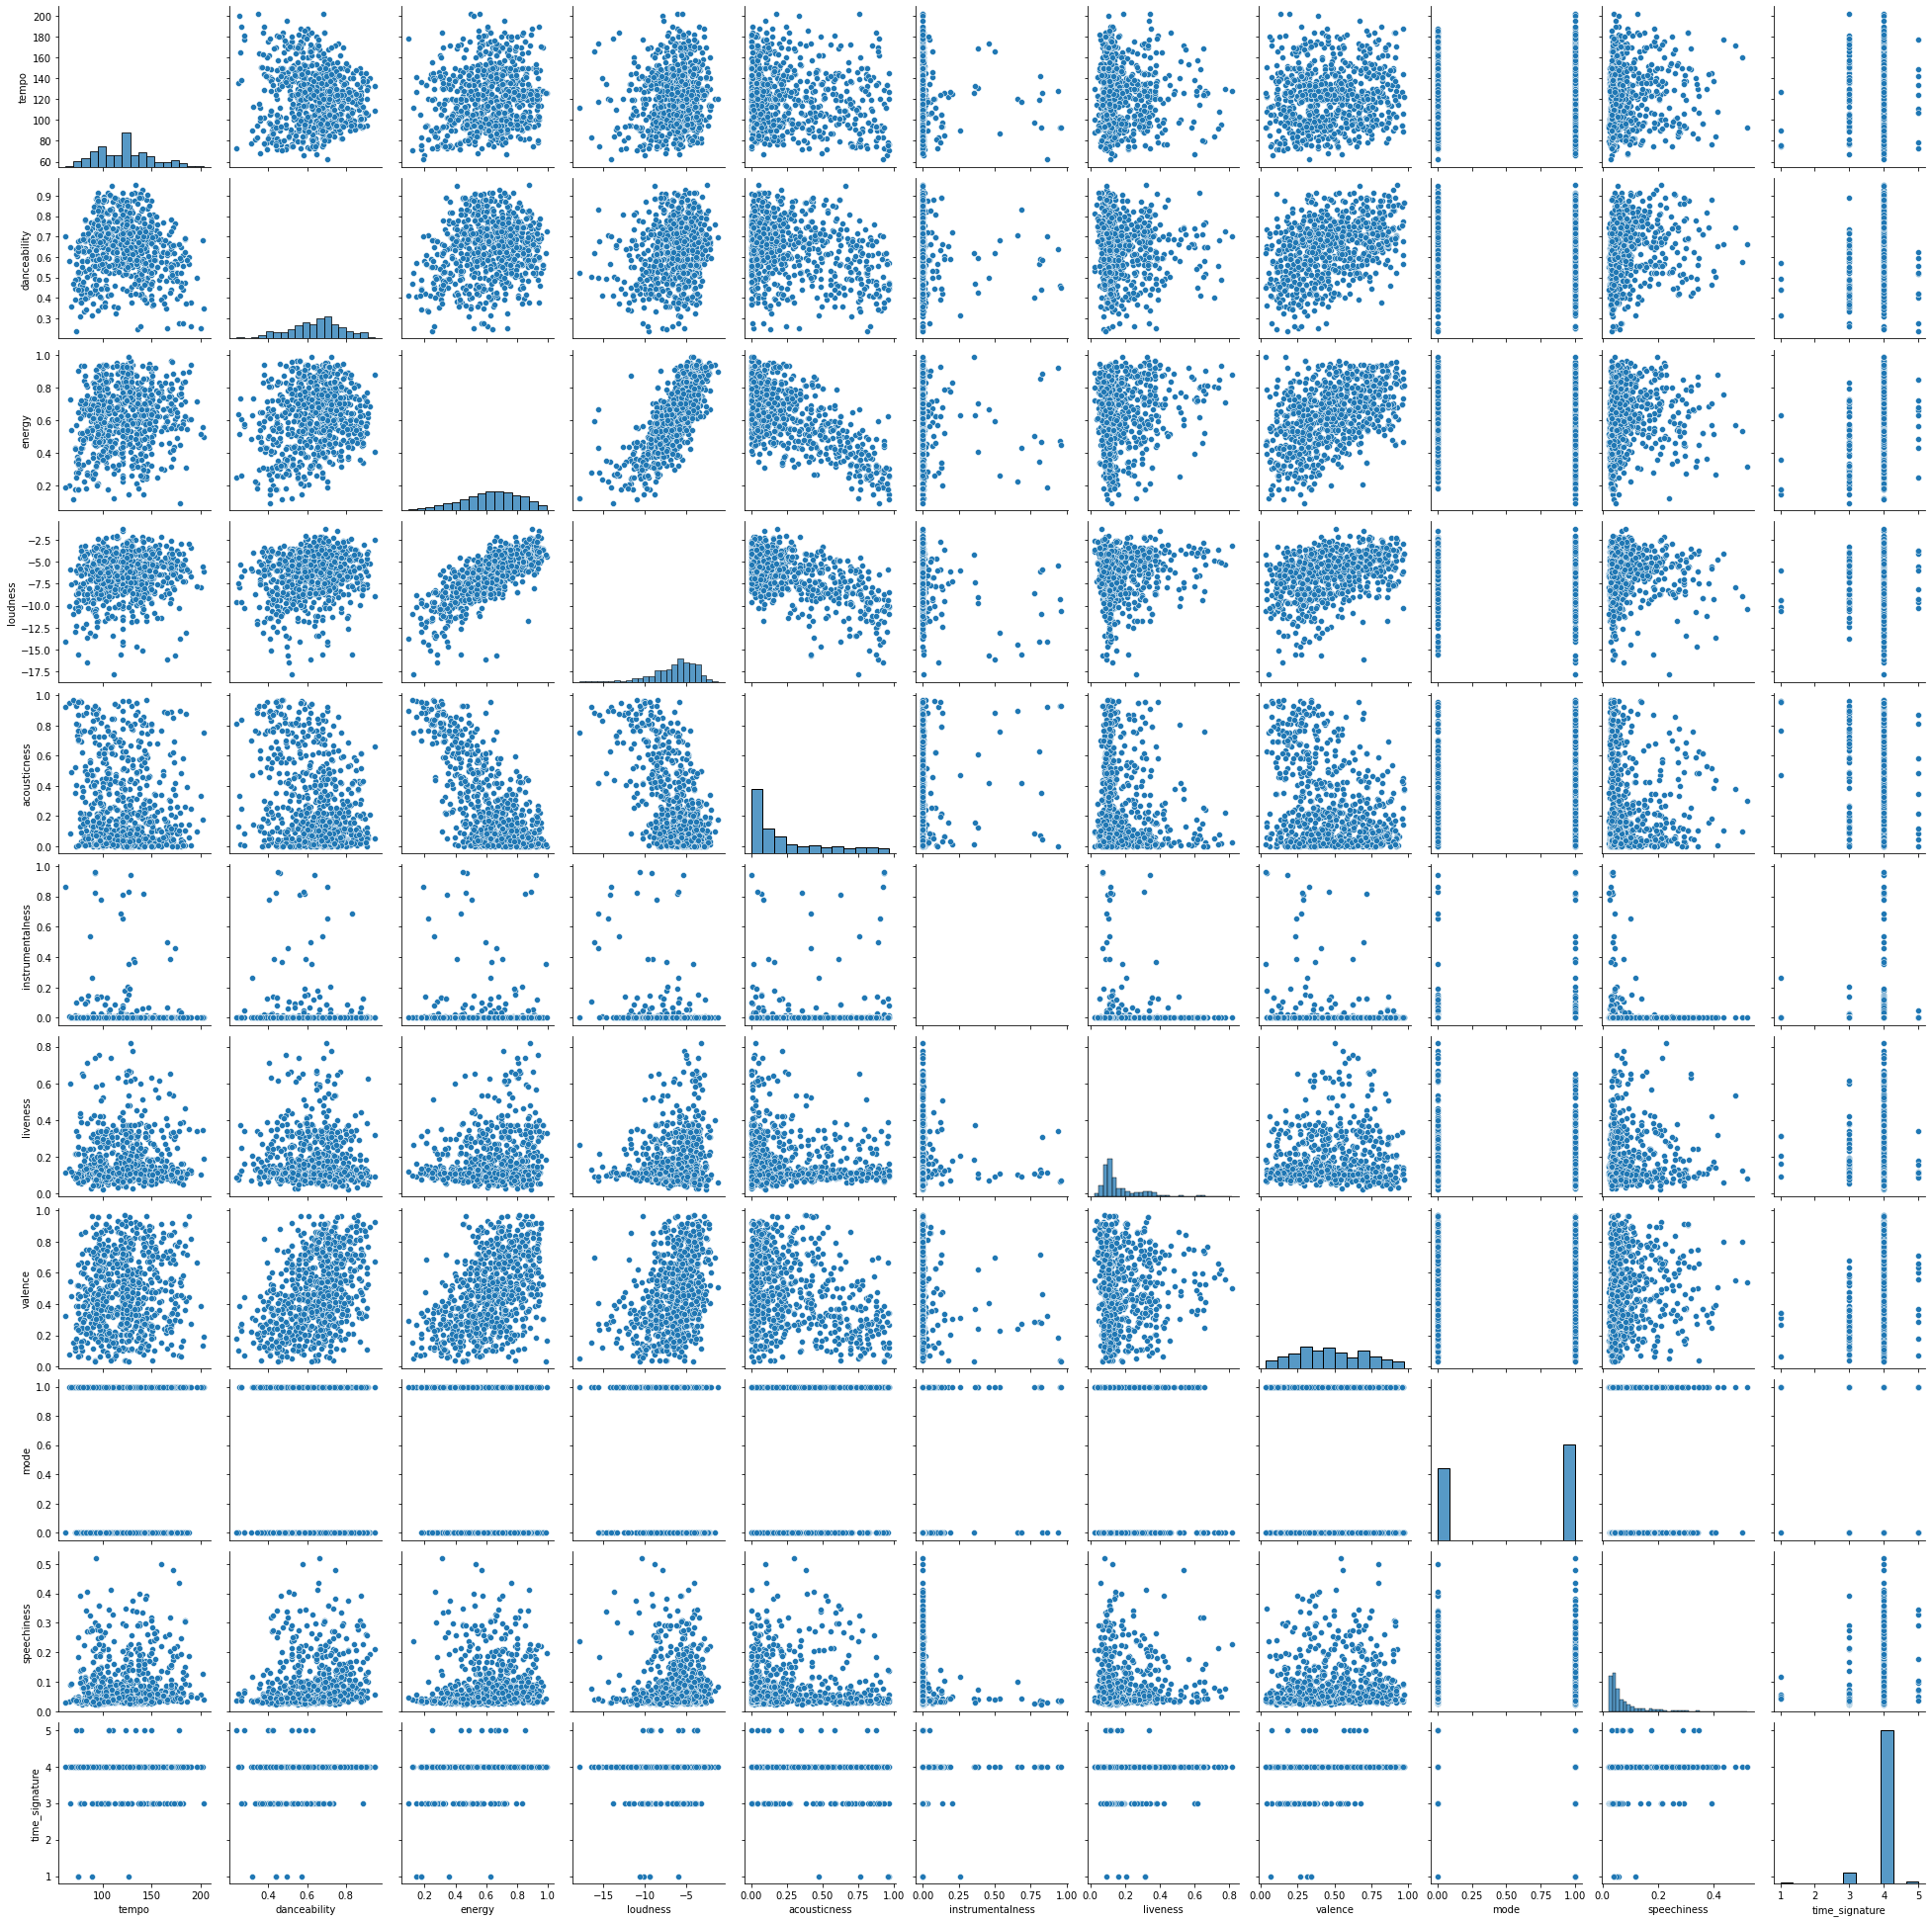

In [68]:
sns.pairplot(df)

In [69]:
df.corr()

,tempo,danceability,energy,loudness,acousticness,instrumentalness,liveness,valence,mode,speechiness,time_signature
tempo,1.000000,-0.100227,0.152535,0.109779,-0.166576,-0.051049,0.044445,0.080221,0.024494,0.107999,0.018218
danceability,-0.100227,1.000000,0.199030,0.234215,-0.272762,-0.089262,-0.058905,0.420445,-0.087258,0.113233,0.214341
energy,0.152535,0.199030,1.000000,0.767857,-0.708532,-0.072161,0.225249,0.477938,-0.141500,0.055936,0.241643
loudness,0.109779,0.234215,0.767857,1.000000,-0.608825,-0.255709,0.163396,0.410884,-0.094877,0.003775,0.133762
acousticness,-0.166576,-0.272762,-0.708532,-0.608825,1.000000,0.122682,-0.158588,-0.316868,0.142159,-0.060913,-0.238453
instrumentalness,-0.051049,-0.089262,-0.072161,-0.255709,0.122682,1.000000,-0.035637,-0.121626,0.016019,-0.099489,0.000415
liveness,0.044445,-0.058905,0.225249,0.163396,-0.158588,-0.035637,1.000000,0.048713,-0.071585,0.019371,-0.022938
valence,0.080221,0.420445,0.477938,0.410884,-0.316868,-0.121626,0.048713,1.000000,-0.061907,0.090345,0.175831
mode,0.024494,-0.087258,-0.141500,-0.094877,0.142159,0.016019,-0.071585,-0.061907,1.000000,-0.073727,-0.064049
speechiness,0.107999,0.113233,0.055936,0.003775,-0.060913,-0.099489,0.019371,0.090345,-0.073727,1.000000,0.077720


When we look at the danceability of a song, we can see a stronger (weak correlation by the number) correlation with valence (0.37) compared to other variables. <br>
### The relationship we will be exploring further is between danceability and valence.

##### lets look at the summary stats for danceability and valence

In [70]:
df[["danceability", "valence"]].describe()

,danceability,valence
count,821.000000,821.000000
mean,0.641473,0.477634
std,0.137323,0.232470
min,0.236000,0.034800
25%,0.556000,0.294000
50%,0.658000,0.460000
75%,0.735000,0.673000
max,0.951000,0.969000


We can see that there is a difference of approx 0.2 between the mean of danceability and valence. This difference (changing by a little) stays for 25%, 50% and 75%. However, the range for valence is larger than that for danceability. This could signify possible signify the presence of outliers.

##### Let us look at the outliers for each of these variables.

<AxesSubplot:>

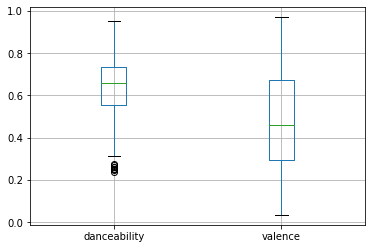

In [71]:
df.boxplot(column=['danceability', 'valence']) #we can see that ther range for valence is much larger than that for dancebilty

##### Let us visualize the distribution of the two variables with bar plots. 

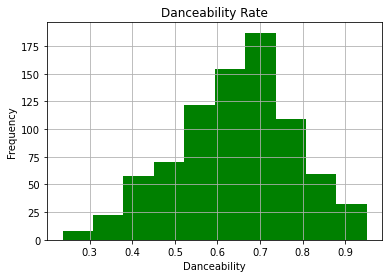

In [72]:
df['danceability'].hist(color='green') 
plt.xlabel('Danceability') 
plt.ylabel('Frequency') 
plt.title('Danceability Rate') 
plt.show() 

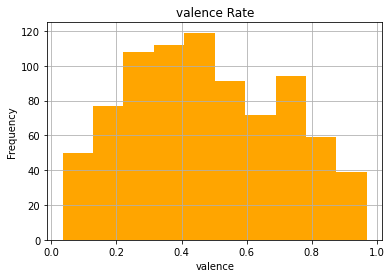

In [73]:
df['valence'].hist(color='orange') 
plt.xlabel('valence') 
plt.ylabel('Frequency') 
plt.title('valence Rate') 
plt.show() 

We can see that distribution is right skewed for the valence while it left skewed for danceability. 

##### Let us plot the realtion between danceability and valence.

slope 0.7117589799613597 intercept 0.02105973807835554 Standard error 0.05367114929611118


<AxesSubplot:xlabel='danceability', ylabel='valence'>

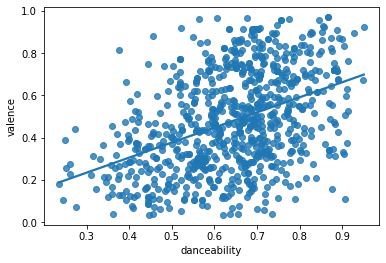

In [74]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['danceability'],df['valence'])
print('slope', slope, 'intercept', intercept, 'Standard error', std_err)
sns.regplot(x='danceability', y = 'valence', data = df,ci = False)

From the slope we can say that for a unit change in danceabilty there is 0.57 change in valence. There is a positive relation between the two and if valence was 0 danceability would be 0.1 .

We can also notice a significant number of outliers from our line of best fit.

#### Now let us explore our categorical variables. We have two categorical variable key and major minor. Since key has many categories it will be easier to see the differences with Major/Minor.

##### Let us look at the boxplots for valence and danceabilty for the major/minor scales.

<AxesSubplot:xlabel='Major_or_Minor', ylabel='danceability'>

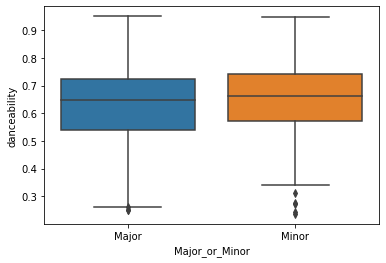

In [75]:
sns.boxplot(x= 'Major_or_Minor', y = 'danceability',data = df)

<AxesSubplot:xlabel='Major_or_Minor', ylabel='valence'>

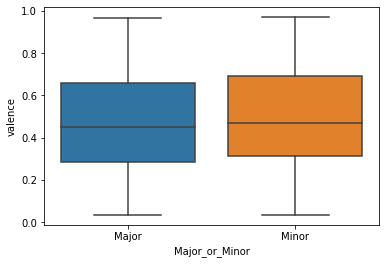

In [76]:
sns.boxplot(x= 'Major_or_Minor', y = 'valence',data = df)

We can see that the major/minor scale has an impact on danceabilty but not much on valence for our dataset.

##### Impact of Major/Minor scale on the relation between Danceability and Valence

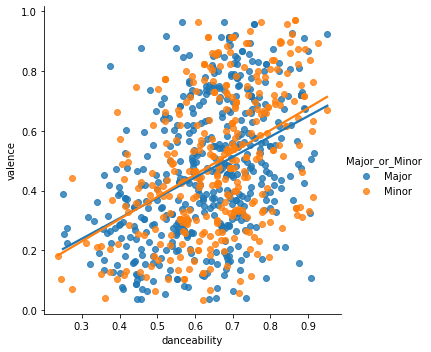

In [77]:

sns.lmplot(x='danceability', y = 'valence', data = df,hue= 'Major_or_Minor', ci = False)

We can see that the slope for the Major scale seems to be more than that for the minor scale.

Let us try to explore the impact of Major/Minor on correlation between variance and danceabilty

In [78]:
df[['danceability', 'valence', 'Major_or_Minor']].groupby('Major_or_Minor').corr()

danceability   valence
Major_or_Minor                                     
Major          danceability      1.000000  0.408294
               valence           0.408294  1.000000
Minor          danceability      1.000000  0.429848
               valence           0.429848  1.000000

Correlation between danceability and Valence is much higher for the Major scale than the minor scale.

### Conclusion:
We can say that there is a positive relation between Danceability and Valence, that is when Valence increases so does danceability. The correlation is stronger for the Major scale than the Minor scale. 

## Inference Analytics
#### Is there sufficient evidence to suggest an association between Energy and the scale (Major/Minor) in the population?
The reason for choosing Energy as our response variable was that it seemed possible for the scale have an impact on the energy of the song. Scale(Major/Minor) is the only two level categorical variable in our dataset


First, let us create two dataframe for Major/Minor scale

In [79]:
df_major=df[df['Major_or_Minor']=='Major']
print(df_major.shape[0]) 
df_major.head() 

469


,track_id,track_name,artist_id,artist_name,album_id,album_name,release_date,tempo,danceability,energy,key,loudness,acousticness,instrumentalness,liveness,valence,mode,speechiness,time_signature,Major_or_Minor
0,2ihCaVdNZmnHZWt0fvAM7B,Little Talks,4dwdTW1Lfiq0cM8nBAqIIz,Of Monsters and Men,4p9dVvZDaZliSjTCbFRhJy,My Head Is An Animal,2012-01-01,102.961,0.457,0.757,C#,-5.177,0.020600,0.000000,0.1460,0.417,1.0,0.0320,4.0,Major
1,77UjLW8j5UAGAGVGhR5oUK,Pray For Me (with Kendrick Lamar),1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,3pLdWdkj83EYfDN6H2N8MR,Black Panther The Album Music From And Inspire...,2018-02-09,100.584,0.735,0.677,D,-4.979,0.076200,0.000022,0.1110,0.188,1.0,0.0930,4.0,Major
4,06cCziAHtDg6pcsidZHu03,Robbers,3mIj9lX2MWuHmhNCA7LSCW,The 1975,0mkOUedmYlOzCC4tOm2v0c,The 1975 (Deluxe Version),2013,99.808,0.621,0.702,E,-6.845,0.000332,0.000015,0.3220,0.374,1.0,0.0295,4.0,Major
9,2q0VexHJirnUPnEOhr2DxK,Biking,2h93pZq0e7k5yf4dywlkpM,Frank Ocean,7yOOPJjNelITCaYMqk8V6r,Biking,2017-04-10,147.981,0.673,0.463,D,-7.247,0.681000,0.000005,0.0907,0.268,1.0,0.1910,4.0,Major
12,2VkuxjlbnbaBiWYpdBGVol,Oh Santa! (feat. Ariana Grande & Jennifer Hudson),4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,5VfesyhwiNgpEEPXlO5c84,Mariah Carey's Magical Christmas Special (Appl...,2020-12-11,78.496,0.648,0.938,C#,-3.298,0.033900,0.000001,0.0564,0.849,1.0,0.1150,4.0,Major


In [80]:
df_minor=df[df['Major_or_Minor']=='Minor']
print(df_minor.shape[0]) 
df_minor.head() 

352


,track_id,track_name,artist_id,artist_name,album_id,album_name,release_date,tempo,danceability,energy,key,loudness,acousticness,instrumentalness,liveness,valence,mode,speechiness,time_signature,Major_or_Minor
2,4B0JvthVoAAuygILe3n4Bs,What Do You Mean?,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,6Fr2rQkZ383FcMqFyT7yPr,Purpose (Deluxe),2015-11-13,125.020,0.845,0.567,F,-8.118,0.5900,0.00142,0.0811,0.793,0.0,0.0956,4.0,Minor
3,6ylDpki1VpIsc525KC1ojF,Tacones Rojos,07YUOmWljBTXwIseAUd9TW,Sebastian Yatra,4qgRDM8Gyurf5hXV3LBmT8,Dharma,2022-01-28,123.014,0.746,0.844,B,-3.499,0.0620,0.00000,0.1490,0.934,0.0,0.0359,4.0,Minor
5,2IO7yf562c1zLzpanal1DT,Gasoline,26VFTg2z8YR0cCuwLzESi2,Halsey,5OZJflQcQCdZLQjtUudCin,BADLANDS (Deluxe),2015-08-28,119.997,0.731,0.580,A#,-7.328,0.2230,0.00000,0.1290,0.319,0.0,0.0399,4.0,Minor
10,2Sh4sAOfnSHEVKFyysxzat,Can't Remember to Forget You (feat. Rihanna),0EmeFodog0BfCgMzAIvKQp,Shakira,4nXeW6UwZGBnv6zops27k4,Shakira. (Expanded Edition),2014-03-14,137.968,0.694,0.810,B,-3.556,0.1220,0.00000,0.1410,0.824,0.0,0.0661,4.0,Minor
11,3wrP2GVxWH8VpHPOsKhYgz,Zero,7bXgB6jMjp9ATFy66eO08Z,Chris Brown,0VWmEVuQ8tA5iA3cCTrgxa,Royalty (Deluxe Version),2015-12-18,120.993,0.731,0.818,C#,-4.564,0.0517,0.00000,0.0743,0.812,0.0,0.0638,4.0,Minor


Let us first calculate the mean and standard error for the sampling distribution of means

In [81]:
import numpy as np
#Major Scale
sampling_dist_of_sample_means_mean_major  = df_major['energy'].mean()
sampling_dist_of_sample_means_std_major = df_major['energy'].std()/np.sqrt(df_major.shape[0])  
print('Mean for major', sampling_dist_of_sample_means_mean_major, ', std_err for major', sampling_dist_of_sample_means_std_major)

#Minor scale
sampling_dist_of_sample_means_mean_minor  = df_minor['energy'].mean()
sampling_dist_of_sample_means_std_minor = df_minor['energy'].std()/np.sqrt(df_minor.shape[0])  
print('Mean for minor', sampling_dist_of_sample_means_mean_minor, ', std_err for minor', sampling_dist_of_sample_means_std_minor)

Mean for major 0.606391897654584 , std_err for major 0.009024254916366235
Mean for minor 0.6599829545454551 , std_err for minor 0.009170750263740177


This sampling distribution of sample means for both major and minor scale is normal because the Central Limit Theorem conditions for sample means are met.
1. [MET] Sample for major scale is randomly selected from the population.
2. [MET] Sample size n=56<10% of the population size.
3. [MET] n=56>30 
4. [MET] Sample for minor scale is randomly selected from the population.
5. [MET] Sample size n=34<10% of the population size.
6. [MET] n=34>30 

#### Setting up the Hypothesis Test
H<sub>0</sub> : μ<sub>1</sub> - μ<sub>2</sub> = 0 <br> 
H<sub>a</sub> : μ<sub>1</sub> - μ<sub>2</sub> ≠ 0 <br>
Where μ<sub>1</sub> is the mean for the major scale and μ<sub>2</sub> is the mean for the minor scale.

#### Conditions for Inference
All of the Central Limit Theorem conditions (for sample mean differences) are met.
1. Sample of major scale songs is randomly selected from the population of all major scale songs.
2. n_major =56<10% of the population.
3. n_major=56>30
4. Sample of minor scale songs  is randomly selected from the population of all minor scale songs.
5.  n_minor = 34 < 10% of the population.
6.  n_minor = 35 > 30
7. The samples of major and minor songs are independent (there was no pairwise relationship in the way in which we collected the two
samples).

#### Calculate P-value
First, let us calculate the test-stat

In [82]:
a = (sampling_dist_of_sample_means_mean_major - sampling_dist_of_sample_means_mean_minor) -(0)
print('difference in means', a)
b = np.sqrt(sampling_dist_of_sample_means_mean_major**2/sampling_dist_of_sample_means_std_major + sampling_dist_of_sample_means_mean_minor**2/sampling_dist_of_sample_means_std_minor)
print(b)
test_stat = a/b
print('test_stat', test_stat)

difference in means -0.05359105689087107
9.393794042979277
test_stat -0.005704942714911223


Let us calculate the P-value

In [83]:
from scipy.stats import t 
 
critical_value = t.ppf(0.975, df=33) # The smaller n is n_minor = 34, then 34-1
p_value = 2*(1-t.cdf(np.abs(test_stat), df=33)) 
print('p_value', p_value)

p_value 0.9954824879935664


#### Conclusion with P Value

Using a significance level of 0.05, we can see p_value 0.99> 0.05. Therefore we cannot reject the null hypothesis, that is μ<sub>1</sub> - μ<sub>2</sub> could be 0. <br>
Therefore, there maybe no association between the scale (Major/Minor) and the Energy of a song

## Linear Regression
1) Is there a linear relation between energy and loudness, valence, liveness, key, acousticness, instrumentalness <br>
(We are picking the variables based on correlation) (Energy was chosen as it seemed to have its variabilty be explained by multiple other variables) (Keys was picked at was the only other categorical variables besides Major/Minor)
2) Is there a linear relation betweenenergy and loudness, valence, liveness, key, acousticness, instrumentalness in the population of all songs in spotify? 

In [84]:
df.corr()

,tempo,danceability,energy,loudness,acousticness,instrumentalness,liveness,valence,mode,speechiness,time_signature
tempo,1.000000,-0.100227,0.152535,0.109779,-0.166576,-0.051049,0.044445,0.080221,0.024494,0.107999,0.018218
danceability,-0.100227,1.000000,0.199030,0.234215,-0.272762,-0.089262,-0.058905,0.420445,-0.087258,0.113233,0.214341
energy,0.152535,0.199030,1.000000,0.767857,-0.708532,-0.072161,0.225249,0.477938,-0.141500,0.055936,0.241643
loudness,0.109779,0.234215,0.767857,1.000000,-0.608825,-0.255709,0.163396,0.410884,-0.094877,0.003775,0.133762
acousticness,-0.166576,-0.272762,-0.708532,-0.608825,1.000000,0.122682,-0.158588,-0.316868,0.142159,-0.060913,-0.238453
instrumentalness,-0.051049,-0.089262,-0.072161,-0.255709,0.122682,1.000000,-0.035637,-0.121626,0.016019,-0.099489,0.000415
liveness,0.044445,-0.058905,0.225249,0.163396,-0.158588,-0.035637,1.000000,0.048713,-0.071585,0.019371,-0.022938
valence,0.080221,0.420445,0.477938,0.410884,-0.316868,-0.121626,0.048713,1.000000,-0.061907,0.090345,0.175831
mode,0.024494,-0.087258,-0.141500,-0.094877,0.142159,0.016019,-0.071585,-0.061907,1.000000,-0.073727,-0.064049
speechiness,0.107999,0.113233,0.055936,0.003775,-0.060913,-0.099489,0.019371,0.090345,-0.073727,1.000000,0.077720


#### Model Fitting

In [85]:
results = smf.ols('energy ~ loudness+ valence+liveness + key+ acousticness+instrumentalness', data = df).fit()
results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     137.3
Date:                Mon, 05 Dec 2022   Prob (F-statistic):          4.66e-217
Time:                        06:53:01   Log-Likelihood:                 750.33
No. Observations:                 821   AIC:                            -1467.
Df Residuals:                     804   BIC:                            -1387.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8605      0.021     40.743      0.000       0.819       0.902
key[T.A#]           -0.0031      0.019     -0.167      0.867      -0.040       0.033
key[T.B]            -0.0174      0.017     -1.034      0.302      -0.050       0.016
key[T.C]            -0.0226      0.017     -1.365      0.173      -0.055       0.010
key[T.C#]           -0.0262      0.016     -1.596      0.111      -0.058       0.006
key[T.D]            -0.0189      0.017     -1.134      0.257      -0.051       0.014
key[T.D#]           -0.0287      0.022     -1.317      0.188      -0.071       0.014
key[T.E]            -0.0338      0.019     -1.797      0.073      -0.071       0.003
key[T.F]            -0.0574      0.017     -3.338      0.001      -0.091      -0.024
key[T.F#]           -0.0284      0.018     -1.595      0.111      -0.063       0.007
key[T.G]            -0.0024      0.017     -0.141      0.888      -0.036       0.031
key[T.G#]           -0.0141      0.018     -0.788      0.431      -0.049       0.021
loudness             0.0375      0.002     20.223      0.000       0.034       0.041
valence              0.1386      0.016      8.414      0.000       0.106       0.171
liveness             0.1165      0.026      4.427      0.000       0.065       0.168
acousticness        -0.2354      0.016    -14.791      0.000      -0.267      -0.204
instrumentalness     0.2236      0.034      6.607      0.000       0.157       0.290
==============================================================================
Omnibus:                        7.302   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.466
Skew:                           0.186   Prob(JB):                       0.0239
Kurtosis:                       3.282   Cond. No.                         94.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Equation
Energy = 0.7092 + 	0.0323*loudness + 0.2017*valence + 0.4029*liveness --0.1873*accousticness+ 0.1436*instrumentalness+ 0.0312*key[T.A#]+ -0.0008*key[T.B]+ -0.0172*key[T.C] + 0.0056*key[T.C#]	+ -0.0128*key[T.D] -0.1365*key[T.D#]+ 	0.0251*key[T.E] + 0.0509*key[T.F]+ 0.0341*key[T.F#] + 0.0688*key[T.G] -0.0770*key[T.G#]

#### Checking the conditions for our model

<b>1. Linearity Condition</b>[Met]: In the fitted values vs. residuals plot below, we see that there are almost equal number of points above and below the line.

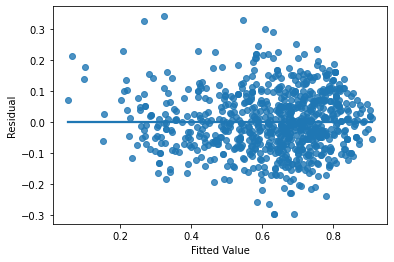

In [86]:
sns.regplot(x=results.fittedvalues, y=results.resid, ci=None) 
plt.ylabel('Residual') 
plt.xlabel('Fitted Value') 
plt.show() 

<b>2. Constant Variance of Residuals Condition</b> [Not met]: In the plot we can see that the residual spread is different as we move from left to right the condition is not me.

<b> 3. Normality of Residuals (with Mean of 0) Condition </b> [Not Met]: The spread is symmetric and unimodal, however, it is not normal

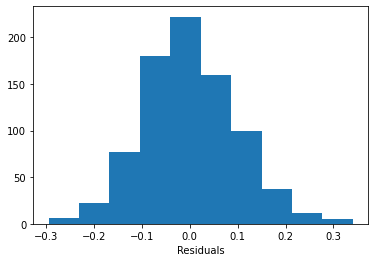

In [87]:

plt.hist(results.resid, bins=10) 
plt.xlabel('Residuals') 
plt.show() 

<b>4. Independence of Residual </b> [Met]: Since the sample is selected randomly and 90 < 10% of the population of all the songs on spotify the condition is not violtaed.

<b> 5. No-Multicollinearity Condition </b> [Met]: As no two variables have a strong linear relation. Condition is not violated

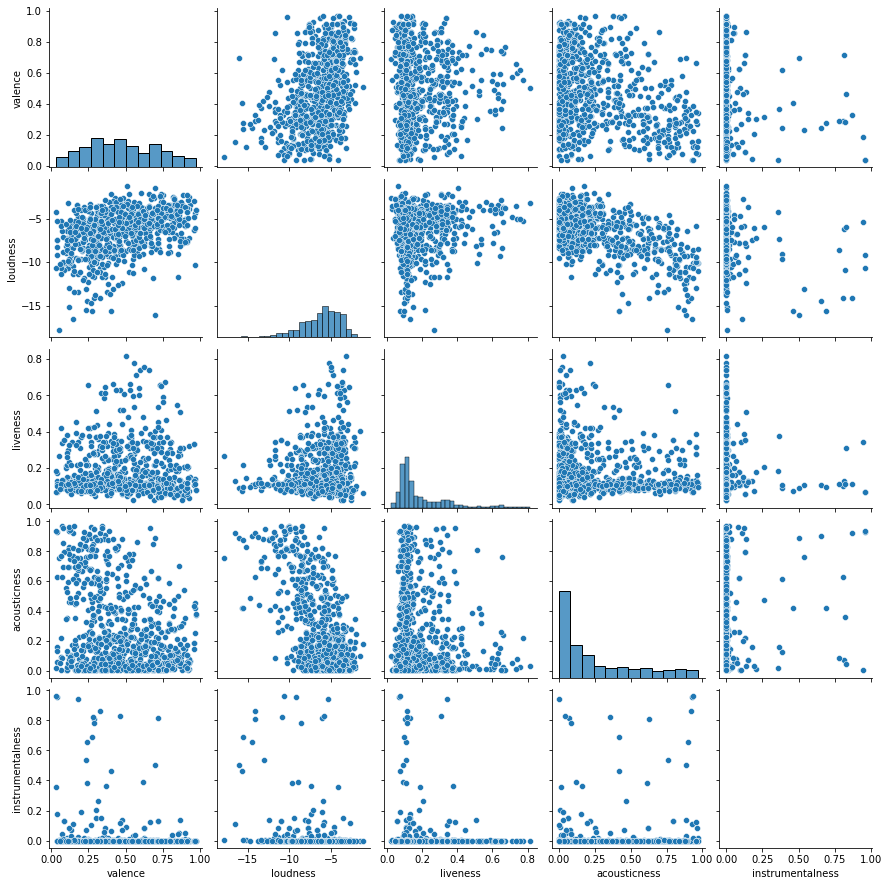

In [88]:
sns.pairplot(df[['valence', 'loudness', 'liveness', 'acousticness', 'instrumentalness']])

#### Assesing the fit of the model

In [89]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     137.3
Date:                Mon, 05 Dec 2022   Prob (F-statistic):          4.66e-217
Time:                        06:55:50   Log-Likelihood:                 750.33
No. Observations:                 821   AIC:                            -1467.
Df Residuals:                     804   BIC:                            -1387.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8605      0.021     40.743      0.000       0.819       0.902
key[T.A#]           -0.0031      0.019     -0.167      0.867      -0.040       0.033
key[T.B]            -0.0174      0.017     -1.034      0.302      -0.050       0.016
key[T.C]            -0.0226      0.017     -1.365      0.173      -0.055       0.010
key[T.C#]           -0.0262      0.016     -1.596      0.111      -0.058       0.006
key[T.D]            -0.0189      0.017     -1.134      0.257      -0.051       0.014
key[T.D#]           -0.0287      0.022     -1.317      0.188      -0.071       0.014
key[T.E]            -0.0338      0.019     -1.797      0.073      -0.071       0.003
key[T.F]            -0.0574      0.017     -3.338      0.001      -0.091      -0.024
key[T.F#]           -0.0284      0.018     -1.595      0.111      -0.063       0.007
key[T.G]            -0.0024      0.017     -0.141      0.888      -0.036       0.031
key[T.G#]           -0.0141      0.018     -0.788      0.431      -0.049       0.021
loudness             0.0375      0.002     20.223      0.000       0.034       0.041
valence              0.1386      0.016      8.414      0.000       0.106       0.171
liveness             0.1165      0.026      4.427      0.000       0.065       0.168
acousticness        -0.2354      0.016    -14.791      0.000      -0.267      -0.204
instrumentalness     0.2236      0.034      6.607      0.000       0.157       0.290
==============================================================================
Omnibus:                        7.302   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.466
Skew:                           0.186   Prob(JB):                       0.0239
Kurtosis:                       3.282   Cond. No.                         94.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R<sup>2</sup> value is 0.759 which indicates a 76% of the variability in energy is explained by our model.

#### Checking Slope values

Let us take a significance level of <b> 0.05 </b> to compare the p-values to check if we have enough evidence to suggest that the slopes are not 0


Note: Our null hypothesis for all slopes will that they are equal to 0.
1) key[T.A#] p_value = 0.594 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0.<br>
2) key[T.B] p_value = 0.987 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0.<br>
3) key[T.C] p_value = 0.727 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0.<br>
4) key[T.C#] p_value = 0.899 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0..<br>
5) key[T.D] p_value = 0.795 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0.<br>
6) key[T.D#] p_value = 0.083 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0.<br>
7) key[T.E] p_value = 0.615 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0.<br>
8) key[T.F] p_value = 	0.295 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0.<br>
9) key[T.F#] p_value = 0.0.462 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0.<br>
10) key[T.G] p_value = 0.135 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0.<br>
11) key[T.G#] p_value = 0.460 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0..<br>
12) Loudness p_value = 0.000 < 0.05. Therefore we cannot reject the null hypothesis and that slope can be 0.<br>
13) Valence p_value = 0.000 < 0.05. Therefore we cannot reject the null hypothesis and that slope can be 0.<br>
14) Liveness p_value = 0.000 < 0.05. Therefore we cannot reject the null hypothesis and that slope can be 0.<br>
15) Acousticness p_value = 0.001 < 0.05. Therefore we cannot reject the null hypothesis and that slope can be 0.<br>
16) Instrumentalness p_value = 0.139 > 0.05. Therefore we can reject the null hypothesis. We can say slope is not 0.<br>

### Conclusion
We can say that there is a linear relationship between energy and loudness, valence, liveness, key, acousticness, instrumentalness. As R^values is 0.759.<br>
<br>
However, we cannot say that the relationship holds for the population as not all conditions for inference were met and the slopes for most numerical variables (leaving Instrumentalness) could be 0.


## Logistic Regression